<a href="https://colab.research.google.com/github/Kumar-Sanket/animalclassification/blob/main/Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# SETUP

!pip install torch torchvision scikit-learn matplotlib tqdm seaborn

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models




In [2]:
#  DATASET

from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = "/content/drive/My Drive/animal_classification/Animal Classification/dataset"

train_dir = os.path.join(DATASET_ROOT, "train")
val_dir   = os.path.join(DATASET_ROOT, "val")
test_dir  = os.path.join(DATASET_ROOT, "test")

# create train/val/test splits
if not os.path.exists(train_dir):
    from sklearn.model_selection import train_test_split

    all_classes = [c for c in os.listdir(DATASET_ROOT) if os.path.isdir(os.path.join(DATASET_ROOT, c))]

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for cls in all_classes:
        cls_dir = os.path.join(DATASET_ROOT, cls)
        images = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('jpg','jpeg','png'))]

        if len(images) == 0:
            print(f"Skipping class {cls} (no images found)")
            continue

        train_files, testval_files = train_test_split(images, test_size=0.3, random_state=42)
        val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

        for subset, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
            out_dir = os.path.join(DATASET_ROOT, subset, cls)
            os.makedirs(out_dir, exist_ok=True)
            for f in files:
                shutil.copy(f, os.path.join(out_dir, os.path.basename(f)))

print("✅ Dataset prepared!")

# Sanity check: count images per split
for split, split_dir in [("Train", train_dir), ("Val", val_dir), ("Test", test_dir)]:
    counts = {cls: len(os.listdir(os.path.join(split_dir, cls))) for cls in os.listdir(split_dir)}
    print(f"{split} counts:", counts)



Mounted at /content/drive
✅ Dataset prepared!
Train counts: {'Panda': 94, 'Tiger': 90, 'Kangaroo': 88, 'Lion': 91, 'Cow': 91, 'Dog': 85, 'Zebra': 95, 'Cat': 86, 'Horse': 91, 'Bear': 87, 'Giraffe': 90, 'Dolphin': 90, 'Bird': 95, 'Elephant': 93, 'Deer': 88}
Val counts: {'Panda': 20, 'Tiger': 19, 'Kangaroo': 19, 'Lion': 20, 'Cow': 20, 'Dog': 18, 'Zebra': 21, 'Cat': 18, 'Horse': 19, 'Bear': 19, 'Giraffe': 19, 'Dolphin': 19, 'Bird': 21, 'Elephant': 20, 'Deer': 19}
Test counts: {'Panda': 21, 'Tiger': 20, 'Kangaroo': 19, 'Lion': 20, 'Cow': 20, 'Dog': 19, 'Zebra': 21, 'Cat': 19, 'Horse': 20, 'Bear': 19, 'Giraffe': 20, 'Dolphin': 20, 'Bird': 21, 'Elephant': 20, 'Deer': 20}


In [3]:

# DATALOADERS

IMG_SIZE = 224
BATCH_SIZE = 32

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir, transform=test_tfms)
test_ds  = datasets.ImageFolder(test_dir, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = train_ds.classes
print("Classes:", classes)


Classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


In [4]:

# MODEL (MobileNetV2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# Enable AMP for faster training
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:00<00:00, 64.9MB/s]
/tmp/ipython-input-267340102.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [6]:

# STRAINING LOOP (AMP)

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in loader:
            x, y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

EPOCHS = 5
best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for x,y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * x.size(0)

    train_loss = running_loss / len(train_ds)
    y_true, y_pred = evaluate(model, val_loader)
    val_acc = (y_true == y_pred).mean()

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print("Training done! Best Val Acc =", best_val_acc)



Epoch 1/5:   0%|          | 0/43 [00:00<?, ?it/s]/tmp/ipython-input-1817837258.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Epoch 1/5: 100%|██████████| 43/43 [04:21<00:00,  6.08s/it]
/tmp/ipython-input-1817837258.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1: Train Loss 0.4682, Val Acc 0.9691


Epoch 2/5: 100%|██████████| 43/43 [04:39<00:00,  6.50s/it]


Epoch 2: Train Loss 0.3690, Val Acc 0.9691


Epoch 3/5: 100%|██████████| 43/43 [04:21<00:00,  6.09s/it]


Epoch 3: Train Loss 0.3215, Val Acc 0.9691


Epoch 4/5: 100%|██████████| 43/43 [04:18<00:00,  6.02s/it]


Epoch 4: Train Loss 0.3222, Val Acc 0.9656


Epoch 5/5: 100%|██████████| 43/43 [04:20<00:00,  6.05s/it]


Epoch 5: Train Loss 0.2793, Val Acc 0.9622
Training done! Best Val Acc = 0.9690721649484536


/tmp/ipython-input-1817837258.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


              precision    recall  f1-score   support

        Bear       0.95      0.95      0.95        19
        Bird       1.00      1.00      1.00        21
         Cat       0.90      1.00      0.95        19
         Cow       0.78      0.90      0.84        20
        Deer       0.95      1.00      0.98        20
         Dog       1.00      0.89      0.94        19
     Dolphin       1.00      1.00      1.00        20
    Elephant       0.95      0.95      0.95        20
     Giraffe       1.00      1.00      1.00        20
       Horse       0.92      0.60      0.73        20
    Kangaroo       0.95      1.00      0.97        19
        Lion       0.91      1.00      0.95        20
       Panda       1.00      1.00      1.00        21
       Tiger       1.00      1.00      1.00        20
       Zebra       1.00      1.00      1.00        21

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.96   

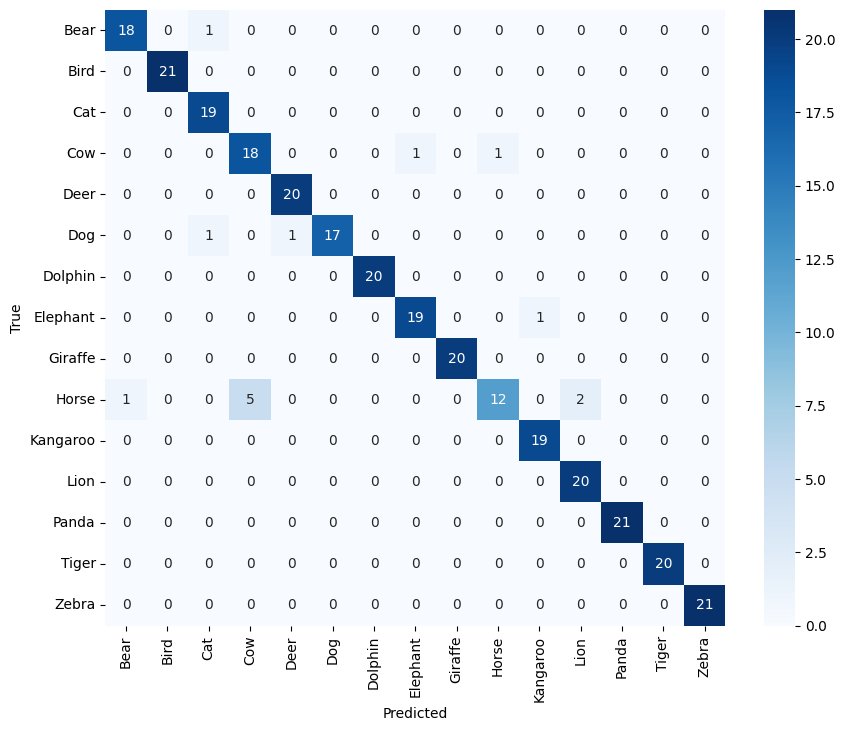

In [7]:

# EVALUATION

model.load_state_dict(torch.load("best_model.pth", map_location=device))

y_true, y_pred = evaluate(model, test_loader)
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [8]:

# INFERENCE

from PIL import Image

def predict_image(img_path, topk=3):
    img = Image.open(img_path).convert("RGB")
    x = test_tfms(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        topk_idx = probs.argsort()[-topk:][::-1]
        return [(classes[i], float(probs[i])) for i in topk_idx]

# run inference on one test image
sample_img = list(test_ds.samples)[0][0]
print("Sample:", sample_img)
print("Predictions:", predict_image(sample_img))


Sample: /content/drive/My Drive/animal_classification/Animal Classification/dataset/test/Bear/Bear_14.jpeg
Predictions: [('Bear', 0.9593348503112793), ('Cow', 0.025554919615387917), ('Elephant', 0.008810888975858688)]


/tmp/ipython-input-3454209134.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Saving Dog_13.jpeg to Dog_13.jpeg
Predicting for: Dog_13.jpeg
Dog: 0.9007
Cat: 0.0820
Panda: 0.0085


/tmp/ipython-input-3454209134.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


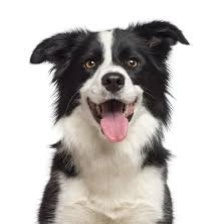

In [9]:

# Optional: Takes image input from the user and guess the animal in the image
from google.colab import files
from PIL import Image

# Upload an image
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    print(f"Predicting for: {img_path}")
    preds = predict_image(img_path, topk=3)
    for cls, prob in preds:
        print(f"{cls}: {prob:.4f}")
    display(Image.open(img_path))
